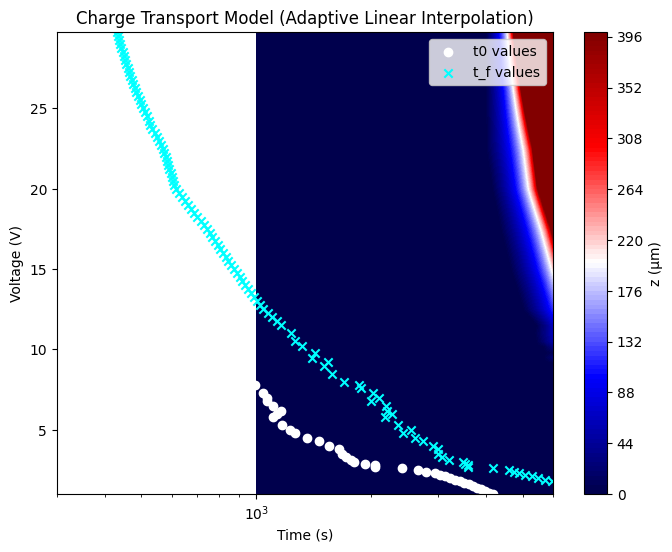

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

# **2단계: V 범위에 따라 새로운 V_fine 생성**
V_low = np.arange(1, 3, 0.1)  # 3V 미만: 0.1V 간격
V_high = np.arange(11.5, max(V_values) + 5, 0.25)  # 11.5V 이상: 0.25V 간격
V_mid = V_values[(V_values >= 3) & (V_values < 11.5)]  # 3V 이상 11.5V 미만: 기존 데이터 유지

V_fine = np.sort(np.concatenate([V_low, V_mid, V_high]))

# **3단계: t0와 mu의 보간**
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_fine = t0_interp(V_fine)
mu_fine = mu_interp(V_fine)

# **4단계: t_f 및 z 계산**
L = 400  
t_grid = np.logspace(np.log10(10), np.log10(6000), 1000)

V_list, t_list, z_list, Vt_list, dzdt_list = [], [], [], [], []
t_f_values = []

z_map = {}

for V, t0, mu in zip(V_fine, t0_fine, mu_fine):
    t_f = t0 + (L**2) / (2 * V * mu)  
    t_f_values.append(t_f)
    
    Vt_values = (V-1.1) * (t_grid - t0)

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    dzdt_values = np.gradient(z_values, t_grid)

    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

    z_map[V] = interp1d(t_grid, z_values, kind="linear", bounds_error=False, fill_value="extrapolate")
    Vt_list.extend(Vt_values)
    dzdt_list.extend(dzdt_values)
    
# **5단계: 중복 제거 및 데이터 저장**
data = np.array([t_list, V_list, z_list, Vt_list, dzdt_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list, Vt_list, dzdt_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2], unique_data[:, 3], unique_data[:, 4]

export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (μm)": z_list, "Vt (V*s)": Vt_list, "dzdt (um/s)": dzdt_list})
export_df.to_csv("data_export5.csv", index=False)

# **6단계: t0 및 t_f 값 저장**
t0_t_f_df = pd.DataFrame({"Voltage (V)": V_fine, "t0 (s)": t0_fine, "t_f (s)": t_f_values})
t0_t_f_df.to_csv("t0_tf_export5.csv", index=False)

# **7단계: Grid 생성 및 플로팅**
Vt_grid, V_grid = np.meshgrid(np.logspace(np.log10(1e3), np.log10(14000), 1000), V_fine)
Z_grid = np.zeros_like(Vt_grid)
dzdt_grid = np.zeros_like(Vt_grid)

for i, V in enumerate(V_fine):
    Z_grid[i, :] = z_map[V](t_grid)

Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=0.5)

cmap_main = plt.get_cmap("seismic")
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

plt.figure(figsize=(8, 6))
c = plt.contourf(Vt_grid, V_grid, Z_grid, levels=100, cmap=custom_cmap)

plt.xscale("log")
plt.colorbar(c, label="z (μm)")
plt.scatter(t0_fine, V_fine, color="white", marker="o", label="t0 values")
plt.scatter(t_f_values, V_fine, color="cyan", marker="x", label="t_f values")

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Charge Transport Model (Adaptive Linear Interpolation)")
plt.xlim(300, 6000)
plt.legend()
plt.show()